# Oja's PCA

In [141]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

## 读取数据

In [142]:
img = Image.open('Lena.bmp').convert('L')
image_data = np.asarray(img, dtype=np.float32) / 255

## 数据预处理

In [143]:
block_size = 8 # 也可以试试 16， 效果更差
num_features = block_size**2

# 使用 reshape 和 transpose 切分为多个 8x8 块
blocks = image_data.reshape(int(image_data.shape[0]/block_size), block_size, int(image_data.shape[1]/block_size), block_size).transpose(0, 2, 1, 3).reshape(-1, block_size, block_size)
# 将每个 8x8 块展平为 64 维向量
flattened_blocks = blocks.reshape(-1, num_features)
# 重新排列展平后的向量，拼接为 64 x 4096 的矩阵
train_data = flattened_blocks.T

## Oja's PCA 迭代公式
$$\mathbf{w}_{t+1}=\mathbf{w}_t+\eta_t\cdot\mathbf{x}_t\cdot(\mathbf{x}_t^\top\mathbf{w}_t-\mathbf{x}_t^\top\mathbf{w}_t\cdot\mathbf{w}_t)$$

In [144]:
def oja_pca(data, max_epochs = 1000, learning_rate = 1e-3, epsilon=0.5e-4, max_e=5):
    # data: (n_samples, n_features)
    n_samples, n_features = data.shape
    W = np.random.randn(n_features)

    count = 0 # 收敛计数器
    for epoch in range(max_epochs):
        X = data[np.random.randint(n_samples)] # 随机选择一个样本

        y = np.dot(X.T, W) # X^T · W
        # dW = learning_rate * y * (X - y * W)
        dW = learning_rate * (X * y - y * y * W)
        W = W + dW

        if np.linalg.norm(dW) < epsilon:
            count += 1
        else:
            count = 0
        if count > max_e: # 连续10次迭代梯度变化小于epsilon，认为收敛
            break
    return W

## 运行

In [145]:
W_pca = oja_pca(train_data) # 获取 PCA 的主成分
compressed_data = np.matmul(W_pca, train_data.T) # 压缩数据

decompressed_data = np.dot(W_pca.T.reshape(-1, 1), compressed_data.reshape(1, -1)) # 解压数据

# 将解压后的数据重新排列为图像
dec_blocks = decompressed_data.reshape(-1, block_size, block_size)  # 形状 (4096, 8, 8)
reconstructed_data = dec_blocks.reshape(int(image_data.shape[0]/block_size), int(image_data.shape[1]/block_size), block_size, block_size).transpose(0, 2, 1, 3).reshape(image_data.shape)

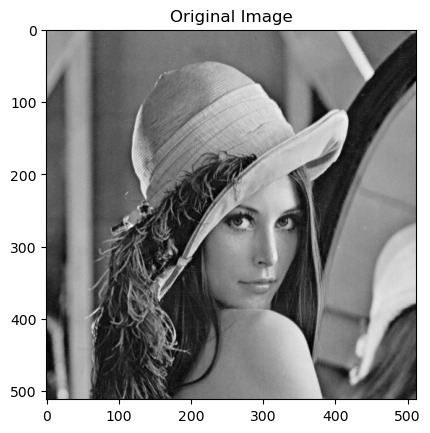

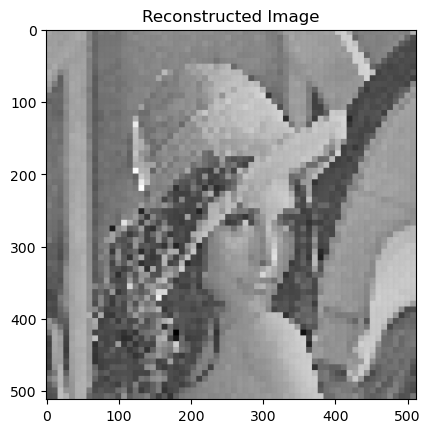

In [146]:
plt.title('Original Image')
plt.imshow(image_data, cmap='gray')
plt.show()

plt.title('Reconstructed Image')
plt.imshow(reconstructed_data, cmap='gray')
plt.show()